In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer

In [2]:
accepted_loans = pd.read_csv('../input/elitedata/elite.csv')

In [3]:
X = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
y = accepted_loans['loan_paid'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

In [6]:
minmax_scaler = ('minmax', MinMaxScaler())

In [7]:
class_weights = [3.2, 3.6, 4.0]

In [8]:
lr = ('lr', LogisticRegression())
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__max_iter': [100, 500, 1000],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__class_weight': [{0: x, 1: 1.0} for x in class_weights]
}

In [9]:
# Metric
f_onehalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [10]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=f_onehalf_scorer,
        return_times=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [11]:
def plot_search_results(search):
    df = pd.DataFrame(search.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

    fig, axes = plt.subplots(1, len(param_grid), 
                          figsize = (7*len(param_grid), 5),
                          sharey='row')
    if len(param_grid) == 1:
        axes = [axes]

    axes[0].set_ylabel("Score", fontsize=25)


    for idx, (param_name, param_range) in enumerate(param_grid.items()):
        try:
            grouped_df = df.groupby(f'param_{param_name}')[results]\
              .agg({'mean_train_score': 'mean',
                    'mean_test_score': 'mean',
                    'std_train_score': 'mean',
                    'std_test_score': 'mean'})

            previous_group = df.groupby(f'param_{param_name}')[results]
            axes[idx].set_xlabel(param_name, fontsize=30)
            axes[idx].set_ylim(0.0, 1.1)
            lw = 2
            axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                      color="darkorange", lw=lw)
            axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                          grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                          color="darkorange", lw=lw)
            axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                      color="navy", lw=lw)
            axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                          grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                          color="navy", lw=lw)
        except:
            pass

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [12]:
def print_result_df(search):
  keeping_columns = ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
  df = pd.DataFrame(search.cv_results_)
  df = df[keeping_columns].sort_values(by='mean_test_score', ascending=False)
  return df.iloc[:10, :]

In [13]:
def print_best_model_result(search, name):
  print("Best parameter (CV score=):" % search.best_score_)
  best_model = search.best_estimator_
  print(best_model)

  y_pred = best_model.predict(X_test)

  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  
  f_onehalf_score = fbeta_score(y_test, y_pred, beta=0.5)
  print('f0.5_score=', f_onehalf_score)

  try :
    y_score = best_model.predict_proba(X_test)[:, 1]
    # calculate precision and recall for each threshold
    precision, recall, threshold = precision_recall_curve(y_test, y_score)
    # calculate scores
    pr_auc = auc(recall, precision)
    print('pr_auc_score=', pr_auc)

    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label=name)
    plt.title(f'{name}(pr_auc={pr_auc})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
  except:
    pass

  return best_model

In [14]:
pipe = Pipeline(steps=[minmax_scaler, lr])

In [15]:
param_grid = lr_param_grid

In [16]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [17]:
search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 13267
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 225
n_resources: 13267
Fitting 10 folds for each of 225 candidates, totalling 2250 fits
[CV 1/10] END lr__C=0.01, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.902, test=0.897) total time=   0.2s
[CV 2/10] END lr__C=0.01, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.901, test=0.901) total time=   0.2s
[CV 3/10] END lr__C=0.01, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.897, test=0.888) total time=   0.2s
[CV 4/10] END lr__C=0.01, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.900, test=0.890) total time=   0.2s
[CV 5/10] END lr__C=0.01, lr__class_weight={0: 3.2,

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.928, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.925) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.924, test=0.920) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.923) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.926, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.934) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.926) total time=   0.3s
[CV 1/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.928, test=0.925) total time=   0.1s
[CV 2/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.933, test=0.925) total time=   0.2s
[CV 3/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.924, test=0.920) total time=   0.2s
[CV 4/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.929) total time=   0.2s
[CV 5/10] END lr__C=1, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.923) total time=   0.1s
[CV 6/1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.927, test=0.928) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.924) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.925, test=0.920) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.923) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.924, test=0.922) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.927, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.934) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.925) total time=   0.4s
[CV 1/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.927, test=0.928) total time=   0.2s
[CV 2/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.924) total time=   0.2s
[CV 3/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.925, test=0.919) total time=   0.2s
[CV 4/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.929) total time=   0.2s
[CV 5/10] END lr__C=1, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.923) total time=   0.2s
[CV 6/1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.926, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.922) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.925, test=0.918) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.926) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.922) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.922, test=0.924) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.927, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.928, test=0.933) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.921) total time=   0.2s
[CV 1/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.926, test=0.928) total time=   0.2s
[CV 2/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.922) total time=   0.2s
[CV 3/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.925, test=0.918) total time=   0.2s
[CV 4/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.929, test=0.926) total time=   0.2s
[CV 5/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.929, test=0.922) total time=   0.3s
[CV 6/1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.925, test=0.918) total time=   1.1s
[CV 4/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.926) total time=   0.7s
[CV 5/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.921) total time=   0.8s
[CV 6/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.922, test=0.924) total time=   0.7s
[CV 7/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.927, test=0.925) total time=   0.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.932) total time=   1.1s
[CV 10/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.921) total time=   0.8s
[CV 1/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.926, test=0.928) total time=   0.4s
[CV 2/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.922) total time=   0.4s
[CV 3/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.925, test=0.918) total time=   0.4s
[CV 4/10] END lr__C=1, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.929, test=0.926) total time=   0.4s
[CV 5/10] END lr__C=1, lr__class_we

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.929) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.928) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.925) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.926) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.929) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.934) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.937) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.928) total time=   0.2s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.929) total time=   0.3s
[CV 2/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.936, test=0.928) total time=   0.2s
[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.925) total time=   0.2s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.934, test=0.931) total time=   0.2s
[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.935, test=0.927) total time=   0.2s
[

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.929) total time=   1.1s
[CV 2/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.928) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.926) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.927) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.930) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.934) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.937) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.929) total time=   1.1s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.929) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.928) total time=   1.2s
[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.925) total time=   0.9s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.931) total time=   1.2s
[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.927) total time=   1.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.931) total time=   1.2s
[CV 7/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.930) total time=   0.8s
[CV 8/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.934) total time=   0.9s
[CV 9/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.938) total time=   1.0s
[CV 10/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.928) total time=   0.9s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.931, test=0.929) total time=   0.6s
[CV 2/10] END lr__C=10

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.930) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.921) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.930) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.929) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.935) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.936) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.929) total time=   0.2s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.931) total time=   0.2s
[CV 2/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.935, test=0.926) total time=   0.3s
[CV 3/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.929, test=0.920) total time=   0.2s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.934, test=0.932) total time=   0.3s
[CV 5/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.934, test=0.927) total time=   0.2s
[

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.933) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.926) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.921) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.929) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.929) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.916, test=0.918) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.932) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.929) total time=   1.1s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.931) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.926) total time=   1.2s
[CV 3/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.929, test=0.921) total time=   0.9s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=   1.1s
[CV 5/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.927) total time=   1.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.929, test=0.930) total time=   1.2s
[CV 7/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.929) total time=   0.7s
[CV 8/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.935) total time=   1.0s
[CV 9/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.936) total time=   1.0s
[CV 10/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.929) total time=   0.9s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.931, test=0.931) total time=   0.5s
[CV 2/10] END lr__C=10

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.934) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.928, test=0.922) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.928) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.928, test=0.930) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.929) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.935) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.934) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.929) total time=   0.2s
[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.934) total time=   0.2s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.934, test=0.926) total time=   0.3s
[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.928, test=0.922) total time=   0.2s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.933, test=0.929) total time=   0.2s
[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.933, test=0.928) total time=   0.2s
[

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.924, test=0.918) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.926) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.927, test=0.922) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.924) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.920, test=0.918) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.929) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.930) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.936) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.929) total time=   1.1s
[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.934) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.926) total time=   1.3s
[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.928, test=0.922) total time=   1.0s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.929) total time=   1.2s
[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.928) total time=   1.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.928, test=0.932) total time=   1.2s
[CV 7/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.928) total time=   0.7s
[CV 8/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.935) total time=   0.9s
[CV 9/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=   1.0s
[CV 10/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.930) total time=   0.9s
[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.931, test=0.934) total time=   0.7s
[CV 2/10] END lr__C=10

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.931) total time=   5.2s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.926) total time=   4.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.899, test=0.895) total time=   5.2s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.929) total time=   2.8s
[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.928) total time=   4.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.931) total time=   5.2s
[CV 7/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.928) total time=   4.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.935) total time=   5.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.922, test=0.919) total time=   5.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.926) total time=   5.2s
[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.934) total time=   0.8s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.926) total time=   1.4s
[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.928, test=0.922) total time=   0.9s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.929) total time=   1.2s
[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.928) total time=   1.1s
[CV 6/10] END lr__C=10, lr__

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.933) total time=  10.2s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.926) total time=   7.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.922) total time=  10.5s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.929) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.926) total time=  10.3s
[CV 6/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.931) total time=   4.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.927) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.932) total time=  10.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.931) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.925) total time=  10.3s
[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.934) total time=   0.7s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.926) total time=   1.4s
[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.928, test=0.922) total time=   0.9s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.929) total time=   1.2s
[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.928) total time=   1.0s
[CV 6/10] END lr__C=10

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.928) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.924) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.933) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.931) total time=   0.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.935) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.938) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.930) total time=   0.2s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.929) total time=   0.3s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.938, test=0.926) total time=   0.4s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.925) total time=   0.3s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.936, test=0.934) total time=   0.3s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.935, test=0.930) total time=   

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.937, test=0.927) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.921) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.933) total time=   1.1s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.930) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.931) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.937, test=0.935) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.938) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.930) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.929) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.938, test=0.928) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.925) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.933) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.929) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.932) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.935) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.938) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.930) total time=   1.2s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.932, test=0.929) total time=   0.7s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.938, test=0.926) total time=   0.8s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.931, test=0.925) total time=   1.0s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.936, test=0.934) total time=   1.2s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.935, test=0.930) total time=   1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.931) total time=   1.1s
[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   0.9s
[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.935) total time=   0.8s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.938) total time=   0.8s
[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.931) total time=   0.8s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.929) total time=   0.3s
[CV 2/10] E

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.934) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.932) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.932) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.936) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.936) total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.929) total time=   0.3s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.934) total time=   0.2s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.937, test=0.926) total time=   0.4s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.923) total time=   0.3s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.935, test=0.932) total time=   0.3s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.935, test=0.930) total time=   

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.925, test=0.919) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.937, test=0.927) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.923) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.931) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.921) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.932) total time=   1.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.931) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.937, test=0.935) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.921, test=0.917) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.931) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.934) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.927) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.923) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.932) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.929) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.934) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.930) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.936) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.936) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.930) total time=   1.3s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.932, test=0.934) total time=   0.7s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.937, test=0.926) total time=   0.8s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.930, test=0.923) total time=   0.8s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.935, test=0.932) total time=   1.4s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.935, test=0.930) total time=   1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.926) total time=   1.1s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.923) total time=   1.0s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.932) total time=   1.0s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.930) total time=   0.8s
[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.933) total time=   1.1s
[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   1.0s
[CV 8/10] END lr

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.924, test=0.921) total time=   5.5s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.932) total time=   2.2s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.929) total time=   3.7s
[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.933) total time=   1.8s
[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.930) total time=   3.6s
[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.937, test=0.937) total time=   1.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.935) total time=   5.4s
[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.930) total time=   2.1s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.934) total time=   1.5s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.927) total time=   4.5s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.923) total time=   1.9s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.932) total time=   1.8s
[CV 5/10] END lr__C=100

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.933) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.932) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.937) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.934) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.930) total time=   0.3s
[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.933) total time=   0.3s
[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.937, test=0.928) total time=   0.4s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.929, test=0.923) total time=   0.3s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.933, test=0.931) total time=   0.3s
[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.934, test=0.928) total time=   

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.924, test=0.915) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.927) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.918, test=0.911) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.930) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.929) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.926, test=0.929) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.929) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.936, test=0.937) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.930) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.927) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.928) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.929, test=0.923) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.929) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.932) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.930) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.937) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.933) total time=   1.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.930) total time=   1.3s
[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.932, test=0.933) total time=   0.7s
[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.937, test=0.928) total time=   0.9s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.929, test=0.923) total time=   0.9s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.933, test=0.931) total time=   1.1s
[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.934, test=0.928) total time=   1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.928) total time=   1.2s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.923) total time=   1.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   1.2s
[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.928) total time=   1.0s
[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.933) total time=   1.2s
[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   1.2s
[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.937, test=0.938) total time=   1.1s
[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.933) total time=   1.0s
[CV 10/10] END l

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.934) total time=   5.7s
[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.937, test=0.928) total time=   4.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.919) total time=   5.6s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=   3.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.928) total time=   5.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.930) total time=   5.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.928) total time=   5.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.935) total time=   5.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.936) total time=   5.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=   5.7s
[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=   1.5s
[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.928) total time=   4.5s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.929, test=0.923) total time=   1.9s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=   1.7s
[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.929) total time=   1.9s
[CV 6/10] END lr__C=10

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.927) total time=  11.0s
[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.937, test=0.928) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.921, test=0.915) total time=  11.2s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=  10.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.926) total time=  10.8s
[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.933) total time=   7.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.928, test=0.929) total time=  11.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.938) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.915, test=0.913) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.928) total time=  10.9s
[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=   1.5s
[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.937, test=0.928) total time=   4.7s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.929, test=0.923) total time=   1.9s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=   1.7s
[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.929) total time=   1.8s
[CV 6/10] END lr

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.935) total time=   4.1s
[CV 2/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.931) total time=   2.6s
[CV 3/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.933) total time=   2.0s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.931) total time=   2.4s
[CV 5/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.932) total time=   2.2s
[CV 6/10] END lr__C=10, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=   2.3s
[CV 7/10] END lr__C=10, lr__

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.934) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.929) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.929, test=0.931) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.930) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.931) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.929) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.929) total time=   0.9s
[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.934, test=0.933) total time=   1.1s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.930) total time=   0.9s
[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.932) total time=   0.8s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.933, test=0.931) total time=   0.8s
[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.930, test=0.931) total time=   0

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.933) total time=   4.2s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.930) total time=   2.7s
[CV 3/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.932) total time=   2.0s
[CV 4/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=   2.4s
[CV 5/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.931) total time=   2.6s
[CV 6/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.930) total time=   2.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.932) total time=   4.3s
[CV 8/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.932) total time=   3.7s
[CV 9/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.930) total time=   2.8s
[CV 10/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.928) total time=   2.7s
[CV 1/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.933) total time=   4.4s
[CV 2/10] END lr__C=10, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.930, test=0.930) total time=   2.7s
[CV 3/10] END lr__C=10, lr_

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.936) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.934) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.934) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.929) total time=   1.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.929) total time=   0.9s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.936) total time=   2.6s
[CV 2/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.933) total time=   3.4s
[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.933) total time=   3.0s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=   3.7s
[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.932) total time=   6.5s
[CV 6/10] END lr__C=10, lr__cla

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.933) total time=   4.0s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=   3.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.932) total time=   3.9s
[CV 6/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.933) total time=   2.7s
[CV 7/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.934) total time=   3.6s
[CV 8/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.931) total time=   3.4s
[CV 9/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.930) total time=   2.4s
[CV 10/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.930) total time=   3.9s
[CV 1/10] END lr__C=100, lr__clas

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.916, test=0.917) total time=  18.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.931) total time=  19.6s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=  17.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.931) total time=  18.6s
[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.931) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.929, test=0.930) total time=  19.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.930, test=0.930) total time=  18.5s
[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.931) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.930) total time=  18.7s
[CV 1/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.937) total time=   4.0s
[CV 2/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=   2.6s
[CV 3/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   2.0s
[CV 4/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.931) total time=   2.2s
[CV 5/10] END lr__C=10, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=   2.2s
[CV 6/10] END lr__C=10

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.936) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.934) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.933) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.935) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   1.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.931) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.936) total time=   3.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.933) total time=   3.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.933) total time=   3.8s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.935, test=0.932) total time=   3.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.933) total time=   3.8s
[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.933) total time=   3.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.934) total time=   3.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=   3.8s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.930) total time=   3.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.930) total time=   3.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.934) total time=   4.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.930) total time=   4.1s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=   4.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.931) total time=   4.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=   4.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   4.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.932) total time=   4.2s
[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=   3.6s
[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.929) total time=   4.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.935) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.930) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.930, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.931) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.932) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.932) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.930) total time=   0.9s
[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.934) total time=  12.6s
[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.930) total time=   8.1s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   2.3s
[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=   5.3s
[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.931) total time=   5.6s
[CV 6/10] END l

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.934) total time=   3.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.930) total time=   3.9s
[CV 3/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   3.5s
[CV 5/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.931) total time=   3.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   3.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   4.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.932) total time=   4.1s
[CV 9/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   2.8s
[CV 10/10] END lr__C=100, lr__class_weight={0: 4.0, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.929) total time=   3.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.936) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.932) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.931) total time=   0.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   0.8s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.936) total time=  13.0s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=   8.3s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   2.3s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.932) total time=   5.1s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=   5.6s
[CV 6/10] END lr__C=

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.933) total time=  37.6s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=   6.5s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.933) total time=   9.8s
[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=  10.5s
[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.931, test=0.934) total time=   9.8s
[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.932) total time=   7.0s
[CV 9/10] END lr__C=10

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.936, test=0.936) total time=   3.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   3.8s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   2.6s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   3.5s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   3.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   3.8s
[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   3.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   3.8s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.932) total time=   3.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   3.6s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.935, test=0.936) total time=   1.1s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.933) total time=   1.2s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.933) total time=   0.7s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.935, test=0.932) total time=   1.0s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.932) total tim

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.936) total time=   4.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=   4.1s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.935, test=0.932) total time=   4.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=   4.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.933) total time=   4.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.934) total time=   3.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.931) total time=   4.0s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.930) total time=   3.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.930) total time=   3.9s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.936) total time=  12.3s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=   7.8s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   2.2s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=   5.2s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   5.5s
[CV 6/10] END lr__C=1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.936) total time=   3.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.933) total time=   4.1s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.931, test=0.933) total time=   2.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.935, test=0.932) total time=   3.6s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=   3.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.933) total time=   3.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.934) total time=   3.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   3.3s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.930) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.930) total time=   3.2s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.936, test=0.936) total time=   0.9s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.932, test=0.932) total time=   1.0s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.933) total time=   0.9s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.934, test=0.932) total time=   1.0s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.931, test=0.933) total time=   

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.936, test=0.936) total time=   4.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=   4.2s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   2.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=   4.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   4.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=   4.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.931, test=0.933) total time=   4.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=   4.0s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.932) total time=   3.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.930) total time=   4.0s
----------
iter: 2
n_candidates: 25
n_resources: 119403
Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.934, test=0.931) total time=  21.2s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.934, test=0.932) total time=  18.3s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.933, test=0.933) total time=  16.7s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.933, test=0.931) total time=  20.1s
[CV 5/10] END lr__C=100, lr__class_weight

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.931) total time=  12.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=  12.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.933) total time=  12.7s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.931) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.932) total time=  12.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.932) total time=  12.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.933) total time=  12.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.933) total time=  13.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.933) total time=  12.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=  12.7s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=  29.0s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=  11.6s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.933) total time=  21.6s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.931) total time=  39.8s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.6, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.932) total time=  22.2s
[CV 6/10] END lr__C=100, l

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=  12.2s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=  11.2s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.933) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.932) total time=  11.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.932) total time=  12.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=  11.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.933) total time=  11.8s
[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.934) total time=  11.8s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.934) total time=  11.8s
[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.933) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.931) total time=  12.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=  12.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.933) total time=  12.6s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.932) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.932) total time=  12.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=  12.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.934) total time=  12.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.934) total time=  12.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.934) total time=  12.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.933) total time=  12.6s
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.931) total time=  12.6s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.934, test=0.932) total time=  10.3s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.933) total time=   9.6s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.933, test=0.932) total time=   9.5s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=sag;, score=(train=0.932, test=0.932) total time=  13.1s
[CV 6/10] END lr__C=1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.931) total time=  11.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=  11.0s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.933) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.932) total time=  10.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.932) total time=  11.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.934) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.934) total time=  10.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.934) total time=  11.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.933) total time=  11.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.931) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.933) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.932) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.932) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.931) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.934) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.933) total time=   3.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.933) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.933) total time=   2.4s
----------
iter: 3
n_candidates: 9
n_resources: 358209
Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.935) total time=  42.4s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=  32.5s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.934) total time=  29.1s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=1000, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=  33.2s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0},

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.935) total time=  39.2s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=  13.7s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.932, test=0.934) total time=   7.4s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.932) total time=  16.5s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.934) total time=  12.7s
[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.934, test=0.933) total time=   9.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.934) total time=  39.6s
[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.933) total time=   9.9s
[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.932) total time=  18.3s
[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.933) total time=  22.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.935) total time=  33.3s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=  33.5s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.932, test=0.934) total time=  28.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.932) total time=  33.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.934) total time=  33.7s
[CV 6/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.934, test=0.933) total time=  29.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.934) total time=  33.5s
[CV 8/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.933) total time=  25.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.932) total time=  34.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.933, test=0.933) total time=  33.5s
----------
iter: 4
n_candidates: 3
n_resources: 1074627
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.934) total time=  42.2s
[CV 2/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.932) total time=  43.4s
[CV 3/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.934) total time=  47.9s
[CV 4/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.933, test=0.933) total time=  29.5s
[CV 5/10] END lr__C=100, lr__class_weight={0: 3.2, 1: 1.0}, lr__ma

HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('lr', LogisticRegression())]),
                    param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                                'lr__class_weight': [{0: 3.2, 1: 1.0},
                                                     {0: 3.6, 1: 1.0},
                                                     {0: 4.0, 1: 1.0}],
                                'lr__max_iter': [100, 500, 1000],
                                'lr__penalty': ['l2'],
                                'lr__solver': ['newton-cg', 'lbfgs',
                                               'liblinear', 'sag', 'saga']},
                    scoring=make_scorer(fbeta_score, beta=0.5), verbose=3)

In [18]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
335,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933255,0.000107,0.933256,0.000357,34.047845,8.343945
334,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933257,0.000104,0.933253,0.000356,34.333146,9.906741
328,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933226,0.000489,0.933251,0.000905,35.100641,6.234118
332,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933222,0.000503,0.933247,0.000917,18.851585,11.069783
336,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933257,0.000111,0.933246,0.000362,122.655254,20.965217
326,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933223,0.000500,0.933243,0.000916,18.481840,12.078935
333,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933224,0.000498,0.933243,0.000922,31.848016,2.694705
331,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933222,0.000502,0.933242,0.000912,91.858908,26.003861
330,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933222,0.000502,0.933242,0.000912,92.099382,26.119280
329,"{'lr__C': 100, 'lr__class_weight': {0: 3.2, 1:...",0.933222,0.000502,0.933242,0.000912,93.604841,26.416349


Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, class_weight={0: 3.2, 1: 1.0},
                                    solver='saga'))])
              precision    recall  f1-score   support

           0       0.54      0.91      0.67     53638
           1       0.97      0.81      0.88    215038

    accuracy                           0.83    268676
   macro avg       0.75      0.86      0.78    268676
weighted avg       0.89      0.83      0.84    268676

[[ 48640   4998]
 [ 41864 173174]]
f0.5_score= 0.9333251412593806
pr_auc_score= 0.9815797945640102


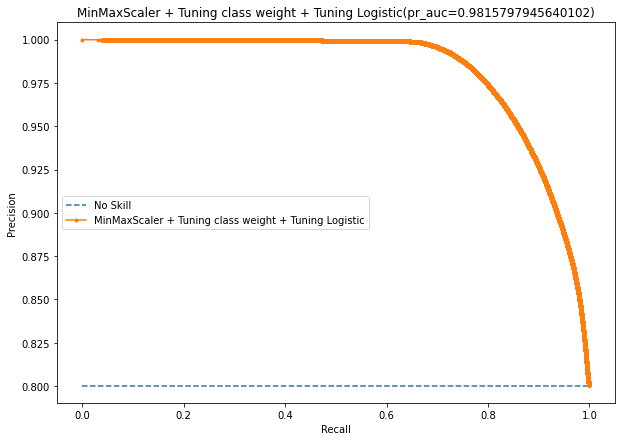

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, class_weight={0: 3.2, 1: 1.0},
                                    solver='saga'))])

In [19]:
print_best_model_result(search, 'MinMaxScaler + Tuning class weight + Tuning Logistic')

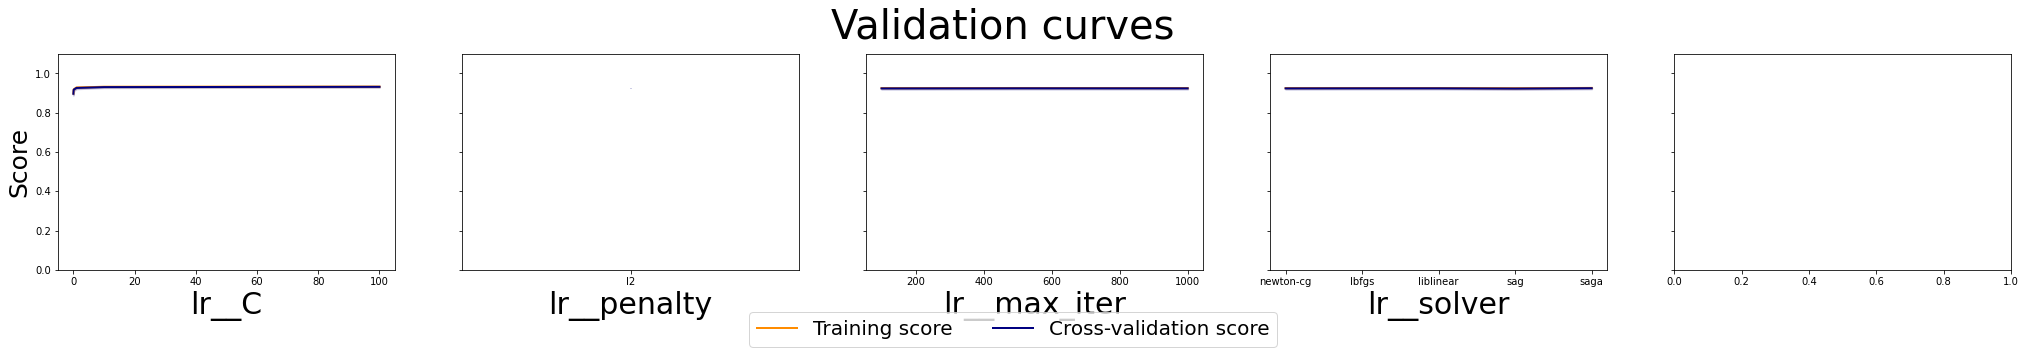

In [20]:
plot_search_results(search)

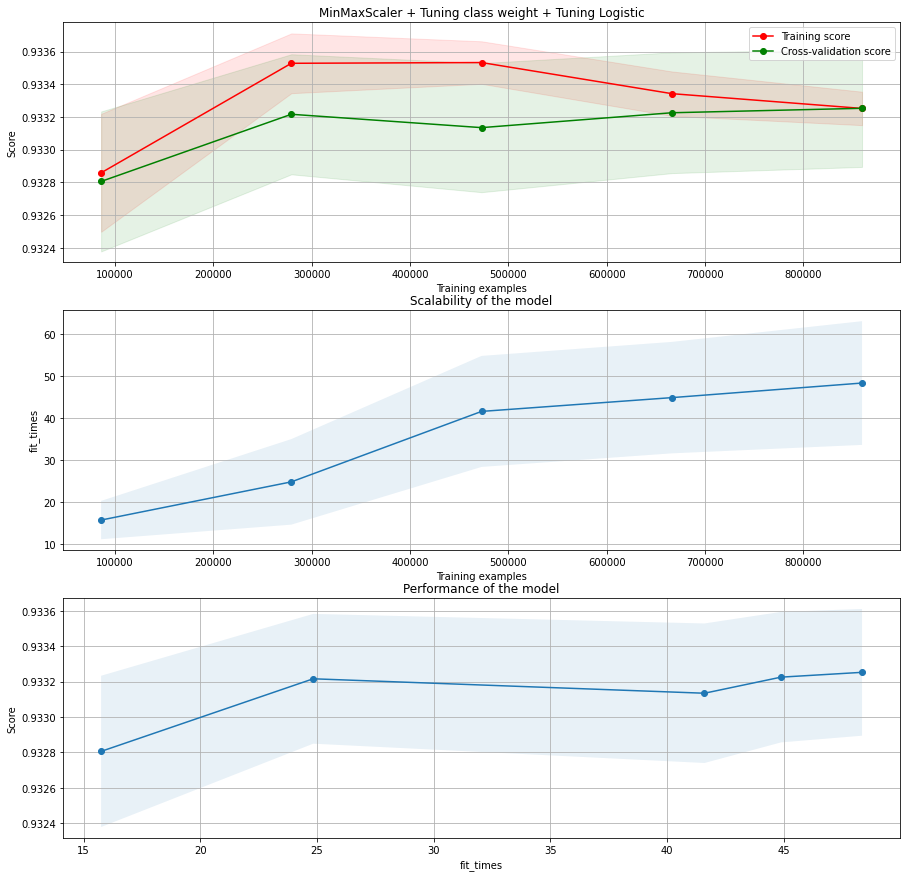

In [21]:
plot_learning_curve(search.best_estimator_, 'MinMaxScaler + Tuning class weight + Tuning Logistic', X_train, y_train, cv=cv, n_jobs=-1)
plt.show()